In [ ]:
! git clone https://github.com/mohammadpz/pytorch_forward_forward.git

fatal: destination path 'pytorch_forward_forward' already exists and is not an empty directory.


## FF MNIST

In [ ]:
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from tqdm import tqdm
from torch.optim import Adam
from torchvision.datasets import MNIST
from torchvision.transforms import Compose, ToTensor, Normalize, Lambda
from torch.utils.data import DataLoader

In [ ]:
def MNIST_loaders(train_batch_size=50000, test_batch_size=10000):

    transform = Compose([
        ToTensor(),
        Normalize((0.1307,), (0.3081,)),
        Lambda(lambda x: torch.flatten(x))])

    train_loader = DataLoader(
        MNIST('./data/', train=True,
              download=True,
              transform=transform),
        batch_size=train_batch_size, shuffle=True)

    test_loader = DataLoader(
        MNIST('./data/', train=False,
              download=True,
              transform=transform),
        batch_size=test_batch_size, shuffle=False)

    return train_loader, test_loader

In [ ]:
def overlay_y_on_x(x, y):
    """Replace the first 10 pixels of data [x] with one-hot-encoded label [y]
    """
    x_ = x.clone()
    x_[:, :10] *= 0.0
    x_[range(x.shape[0]), y] = x.max()
    return x_

In [ ]:
class Net(torch.nn.Module):

    def __init__(self, dims):
        super().__init__()
        self.layers = []
        for d in range(len(dims) - 1):
            self.layers += [Layer(dims[d], dims[d + 1])]#.cuda()

    def predict(self, x):
        goodness_per_label = []
        for label in range(10):
            h = overlay_y_on_x(x, label)
            goodness = []
            for layer in self.layers:
                h = layer(h)
                goodness += [h.pow(2).mean(1)]
            goodness_per_label += [sum(goodness).unsqueeze(1)]
        goodness_per_label = torch.cat(goodness_per_label, 1)
        return goodness_per_label.argmax(1)

    def train(self, x_pos, x_neg):
        h_pos, h_neg = x_pos, x_neg
        for i, layer in enumerate(self.layers):
            print('training layer', i, '...')
            h_pos, h_neg = layer.train(h_pos, h_neg)



NameError: ignored

In [ ]:
class Layer(nn.Linear):
    def __init__(self, in_features, out_features,
                 bias=True, device=None, dtype=None):
        super().__init__(in_features, out_features, bias, device, dtype)
        self.relu = torch.nn.ReLU()
        self.opt = Adam(self.parameters(), lr=0.03)
        self.threshold = 2.0
        self.num_epochs = 1000

    def forward(self, x):
        x_direction = x / (x.norm(2, 1, keepdim=True) + 1e-4)
        return self.relu(
            torch.mm(x_direction, self.weight.T) +
            self.bias.unsqueeze(0))

    def train(self, x_pos, x_neg):
        for i in tqdm(range(self.num_epochs)):
            g_pos = self.forward(x_pos).pow(2).mean(1)
            g_neg = self.forward(x_neg).pow(2).mean(1)
            # The following loss pushes pos (neg) samples to
            # values larger (smaller) than the self.threshold.
            loss = torch.log(1 + torch.exp(torch.cat([
                -g_pos + self.threshold,
                g_neg - self.threshold]))).mean()
            self.opt.zero_grad()
            # this backward just compute the derivative and hence
            # is not considered backpropagation.
            loss.backward()
            self.opt.step()
        return self.forward(x_pos).detach(), self.forward(x_neg).detach()

    


In [ ]:
def visualize_sample(data, name='', idx=0):
    reshaped = data[idx].cpu().reshape(28, 28)
    plt.figure(figsize = (4, 4))
    plt.title(name)
    plt.imshow(reshaped, cmap="gray")
    plt.show()
    
    


torch.Size([50000, 784]) torch.Size([50000])


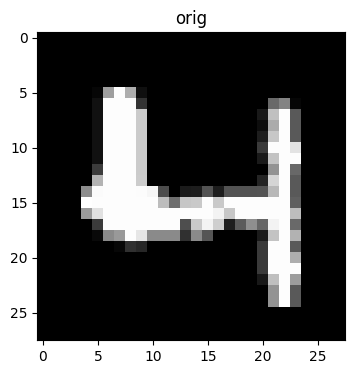

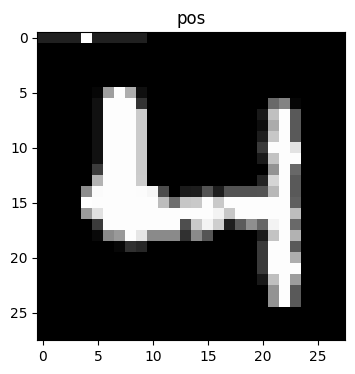

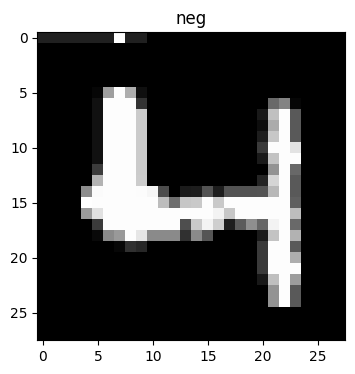

training layer 0 ...


  0%|          | 0/1000 [00:00<?, ?it/s]


RuntimeError: ignored

In [ ]:
if __name__ == "__main__":
    torch.manual_seed(1234)
    train_loader, test_loader = MNIST_loaders()

    net = Net([784, 500, 500])
    x, y = next(iter(train_loader))
    x, y = x.cuda(), y.cuda()
    print(x.shape, y.shape)
    x_pos = overlay_y_on_x(x, y).cuda()
    rnd = torch.randperm(x.size(0))
    x_neg = overlay_y_on_x(x, y[rnd]).cuda()
    
    for data, name in zip([x, x_pos, x_neg], ['orig', 'pos', 'neg']):
        visualize_sample(data, name)
    
    net.train(x_pos, x_neg).cuda()

    print('train error:', 1.0 - net.predict(x).eq(y).float().mean().item())

    x_te, y_te = next(iter(test_loader))
    x_te, y_te = x_te.cuda(), y_te.cuda()

    print('test error:', 1.0 - net.predict(x_te).eq(y_te).float().mean().item())


## CNN MNIST

In [ ]:
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from tqdm import tqdm
from torch.optim import Adam
from torchvision.datasets import MNIST
from torchvision.transforms import Compose, ToTensor, Normalize, Lambda
from torch.utils.data import DataLoader

In [ ]:
def MNIST_loaders(train_batch_size=50000, test_batch_size=10000):

    transform = Compose([
        ToTensor(),
        Normalize((0.1307,), (0.3081,))])

    train_loader = DataLoader(
        MNIST('./data/', train=True,
              download=True,
              transform=transform),
        batch_size=train_batch_size, shuffle=True)

    test_loader = DataLoader(
        MNIST('./data/', train=False,
              download=True,
              transform=transform),
        batch_size=test_batch_size, shuffle=False)

    return train_loader, test_loader

In [ ]:
def overlay_y_on_x(x, y):
    """Replace the first 10 pixels of data [x] with one-hot-encoded label [y]
    """
    x_ = x.clone()
    x_ = x_.reshape(-1, 1 * 28 * 28)
    x_[:, :10] *= 0.0
    x_[range(x_.shape[0]), y] = x.max()
    return x_.reshape(-1, 1, 28, 28)

In [ ]:
class Net(torch.nn.Module):

    def __init__(self, layers):
        super().__init__()
        self.layers = [layer.cuda() for layer in layers]
        
    def predict(self, x):
        goodness_per_label = []
        for label in range(10):
            h = overlay_y_on_x(x, label)
            goodness = []
            for layer in self.layers:
                h = layer(h)
                goodness += [h.pow(2).mean(1).sum()]
            goodness_per_label += [sum(goodness)] #[sum(goodness).unsqueeze(1)]
        # goodness_per_label = torch.cat(goodness_per_label, 1)
        # return goodness_per_label.argmax(1)
        return torch.tensor(goodness_per_label.index(max(goodness_per_label)))

    def train(self, x_pos, x_neg):
        h_pos, h_neg = x_pos, x_neg
        for i, layer in enumerate(self.layers):
            print('training layer', i, '...')
            h_pos, h_neg = layer.train(h_pos, h_neg)



In [ ]:
class FlattenLayer(nn.Flatten):

  def train(self, x_pos, x_neg):
    return self.forward(x_pos).detach(), self.forward(x_neg).detach()

class MaxPoolLayer(nn.MaxPool2d):

  def train(self, x_pos, x_neg):
    return  self.forward(x_pos).detach(), self.forward(x_neg).detach()

In [ ]:
class Conv2DLayer(nn.Conv2d):
    def __init__(self, in_channels, out_channels, kernel_size, stride=1, padding=0, dilation=1, groups=1, bias=True):
        super(Conv2DLayer, self).__init__(in_channels, out_channels, kernel_size, stride, padding, dilation, groups, bias)
        self.relu = torch.nn.ReLU()
        self.opt = Adam(self.parameters(), lr=0.03)
        self.threshold = 2.0
        self.num_epochs = 1000

    def forward(self, x):
        x_direction = x / (x.norm(2, 1, keepdim=True) + 1e-4)
        return self.relu(super(Conv2DLayer, self).forward(x_direction))
        
    def train(self, x_pos, x_neg):
        for i in tqdm(range(self.num_epochs)):
            g_pos = self.forward(x_pos).pow(2).mean(1)
            g_neg = self.forward(x_neg).pow(2).mean(1)
            # The following loss pushes pos (neg) samples to
            # values larger (smaller) than the self.threshold.
            loss = torch.log(1 + torch.exp(torch.cat([
                -g_pos + self.threshold,
                g_neg - self.threshold]))).mean()
            self.opt.zero_grad()
            # this backward just compute the derivative and hence
            # is not considered backpropagation.
            loss.backward()
            self.opt.step()
        return self.forward(x_pos).detach(), self.forward(x_neg).detach()


In [ ]:
class LinearLayer(nn.Linear):
    def __init__(self, in_features, out_features,
                 bias=True, device=None, dtype=None):
        super().__init__(in_features, out_features, bias, device, dtype)
        self.relu = torch.nn.ReLU()
        self.opt = Adam(self.parameters(), lr=0.03)
        self.threshold = 2.0
        self.num_epochs = 1000

    def forward(self, x):
        x_direction = x / (x.norm(2, 1, keepdim=True) + 1e-4)
        return self.relu(
            torch.mm(x_direction, self.weight.T) +
            self.bias.unsqueeze(0))

    def train(self, x_pos, x_neg):
        for i in tqdm(range(self.num_epochs)):
            g_pos = self.forward(x_pos).pow(2).mean(1)
            g_neg = self.forward(x_neg).pow(2).mean(1)
            # The following loss pushes pos (neg) samples to
            # values larger (smaller) than the self.threshold.
            loss = torch.log(1 + torch.exp(torch.cat([
                -g_pos + self.threshold,
                g_neg - self.threshold]))).mean()
            self.opt.zero_grad()
            # this backward just compute the derivative and hence
            # is not considered backpropagation.
            loss.backward()
            self.opt.step()
        return self.forward(x_pos).detach(), self.forward(x_neg).detach()


In [ ]:
def visualize_sample(data, name='', idx=0):
    reshaped = data[idx].cpu().reshape(28, 28)
    plt.figure(figsize = (4, 4))
    plt.title(name)
    plt.imshow(reshaped, cmap="gray")
    plt.show()

In [ ]:
torch.manual_seed(1234)
train_loader, test_loader = MNIST_loaders(train_batch_size=5000, test_batch_size=5000)

layers = [
    Conv2DLayer(in_channels=1, out_channels=6, kernel_size=5, padding=2),
    MaxPoolLayer(kernel_size=2, stride=2),
    Conv2DLayer(in_channels=6, out_channels=16, kernel_size=5),
    MaxPoolLayer(kernel_size=2, stride=2),
    FlattenLayer(),
    LinearLayer(16 * 5 * 5, 120),
    LinearLayer(120, 84),
    LinearLayer(84, 10)
]

net = Net(layers)
train_error = 0
num_batch = 0
for (x, y) in iter(train_loader):


# x, y = next(iter(train_loader))
  # print(x.shape, y.shape)
  x, y = x.cuda(), y.cuda()
  x_pos = overlay_y_on_x(x, y)
  rnd = torch.randperm(x.size(0))
  x_neg = overlay_y_on_x(x, y[rnd])



  # for data, name in zip([x, x_pos, x_neg], ['orig', 'pos', 'neg']):
  #     visualize_sample(data, name)

  net.train(x_pos, x_neg)

  train_error += 1.0 - net.predict(x).eq(y).float().mean().item()
  num_batch += 1
  print('total train error', train_error / num_batch)
  print('batch train error:', 1.0 - net.predict(x).eq(y).float().mean().item())
test_error = 0
num_batch = 0
for (x_te, y_te) in iter(test_loader):
  x_te, y_te = x_te.cuda(), y_te.cuda()
  test_error += 1.0 - net.predict(x_te).eq(y_te).float().mean().item()
  num_batch += 1
  print('total test error', test_error / num_batch)
  print('batch test error:', 1.0 - net.predict(x_te).eq(y_te).float().mean().item())
print('train error:', train_error / (50000/5000))
print('test error:', test_error / (10000/5000))

training layer 0 ...


100%|██████████| 1000/1000 [00:31<00:00, 31.92it/s]


training layer 1 ...
training layer 2 ...


100%|██████████| 1000/1000 [00:14<00:00, 70.59it/s]


training layer 3 ...
training layer 4 ...
training layer 5 ...


100%|██████████| 1000/1000 [00:01<00:00, 538.68it/s]


training layer 6 ...


100%|██████████| 1000/1000 [00:01<00:00, 629.79it/s]


training layer 7 ...


100%|██████████| 1000/1000 [00:01<00:00, 642.97it/s]


total train error 0.9060000032186508
batch train error: 0.9060000032186508
training layer 0 ...


 37%|███▋      | 367/1000 [00:10<00:18, 33.82it/s]


KeyboardInterrupt: ignored